In [ ]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Template to run a T5X job on Vertex AI

This notebook serves as a template for configuring and running a T5X job on
Google Vertex AI. The job can be a fine-tuning job or a training job from
scratch, or it can be an evaluation job or an inference job. The template lets
you clone the notebook for a specific job, task, dataset, or configuration and
get a quick start on running a T5X job on Vertex AI.

## Objective

This template notebook performs three tasks. First, it runs through a
fine-tuning job from a pre-trained model for an English to German translation
task using the [T5X framework](https://github.com/google-research/t5x) on
[Vertex AI](https://cloud.google.com/vertex-ai) with the
[`wmt_t2t_translate`](https://www.tensorflow.org/datasets/catalog/wmt_t2t_translate)
dataset. It then performs the additional tasks of evaluation and of batch
inference on the fine-tuned model. 

The notebook is organized as following:

-  [Preparation: Imports and initialization](#preparation):
    Initialize and configure an experiment for any of the tasks to run.
-  [Task 1: Fine-tune a pre-trained model on Vertex AI](#task1):
    Configure and fine-tune a pretrained T5 base model for translation task
    with T5X on Vertex AI.
-  [Task 2: Run model evaluation on Vertex AI](#task2):
    Configure and evaluate a trained model with T5X on Vertex AI.
-  [Task 3: Run batch inference on Vertex AI](#task3):
    Configure and run batch inference using the trained model with T5X on Vertex AI.

## Before you begin

Before you run this notebook, review the prerequisites:

1. For background about how to run and monitor T5X jobs with Vertex AI,
    including environment setup and data preparation tasks, see the [README
    file](README.md) for this repository.
1. Ensure that you have set up the development environment and installed the
    required libraries as described in the environment setup of the [README
    file](README.md). 

## <a name="preparation"></a>Preparation: Imports and initialization

In this section, you import required libraries, configure environment settings,
and initialize an experiment in Vertex AI.

Call the
[`autoreload`](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html)
extension to reload modules automatically before executing code.

In [ ]:
# Reloads modules automatically before executing any code/script
%load_ext autoreload
%autoreload 2

### Import libraries

Import the required libraries.

In [ ]:
import os
import time
from datetime import datetime
import pandas as pd

# Import the Vertex AI SDK for Python
from google.cloud import aiplatform as vertex_ai

Import [`utils.py`](utils.py), which is a
custom script that has utility functions to streamline configuration and
submission of a Vertex AI custom job and to track the generated artifacts and
metrics from the custom job.

In [ ]:
import utils

Authenticate to Google Cloud using the default application credential provided by Vertex AI Workbench.

In [ ]:
import google.auth
from google.auth import credentials as auth_credentials
from google.api_core.client_info import ClientInfo

source_credentials, _ = google.auth.default()
request = google.auth.transport.requests.Request()
source_credentials.refresh(request)
source_credentials.apply(headers = {'user-agent': 'cloud-solutions/t5x-on-vertex-ai-v1.0'})
source_credentials.refresh(request)
if source_credentials.valid:
  print('Authenticated')

### Configure environment settings

Based on the [environment setup](README.md) you did previously, configure the
following environment settings:

-  `PROJECT_ID`: Configure the Google Cloud project ID.
-  `REGION`: Configure the
    [region](https://cloud.google.com/vertex-ai/docs/general/locations) to use
    for Vertex AI operations throughout this notebook.
-  `BUCKET`: Configure the Google Cloud Storage bucket name that you created
    during environment setup. Vertex AI uses this bucket for operations such as
    staging the code and saving generated artifacts.
-  `TENSORBOARD_NAME`: Configure the managed TensorBoard instance name that
    you created during the environment setup.

In [ ]:
# Project definitions
PROJECT_ID = '<YOUR PROJECT ID>' # Change to your project id.
REGION = '<YOUR REGION>'  # Change to your region.

# Bucket definitions
BUCKET = '<YOUR BUCKET NAME>' # Change to your bucket.

In [ ]:
# Tensorboard definitions
TENSORBOARD_NAME = '<YOUR TENSORBOARD NAME>' # Change to your Tensorboard instance name

In [ ]:
# Get Vertex AI TensorBoard ID based on name
TENSORBOARD_ID = ! gcloud ai tensorboards list --filter="displayName={TENSORBOARD_NAME}" --format="value(name)" --region={REGION} 2>/dev/null 
TENSORBOARD_ID = TENSORBOARD_ID[0]

print(f"TENSORBOARD_ID = {TENSORBOARD_ID}")

### Configure a custom container image

The notebook uses
[Vertex AI custom training jobs](https://cloud.google.com/vertex-ai/docs/training/create-custom-job)
with a
[custom training container](https://cloud.google.com/vertex-ai/docs/training/containers-overview)
to run T5X training, evaluation, and inference tasks. The
[base custom training container image](Dockerfile)
that you created as part of the environment setup
packages the T5X framework and its dependencies and sets the default entrypoint
to the T5X launch script.

Most samples in the repository use the base custom training container image
`t5x-base` directly. When you are deriving an image from the base container
image, configure your custom container image name (`IMAGE_NAME`) as shown in the
following code:

In [ ]:
# Configure the custom container image name
IMAGE_NAME = 't5x-base' # Change to your image name
IMAGE_URI = f'gcr.io/{PROJECT_ID}/{IMAGE_NAME}'

Verify that the image exists in Container Registry:

In [ ]:
! gcloud container images describe $IMAGE_URI

If the results show that the image exists, then the step is completed correctly.
If the results show that image does not exist, review the preceding steps and
try them again. Don't proceed in the notebook until this verification step shows
success.

### Configure experiment settings

The notebook uses Vertex AI Experiments to track the run, including
configuration, dataset location, artifacts, and metrics for reproducibility.
Configure the experiment name, and set the workspace and run settings.

In [ ]:
EXPERIMENT_NAME = '<YOUR EXPERIMENT NAME>' # Change to your experiment name

EXPERIMENT_WORKSPACE = f'gs://{BUCKET}/experiments/{EXPERIMENT_NAME}'
EXPERIMENT_RUNS = f'{EXPERIMENT_WORKSPACE}/runs'

### Initialize the Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project, bucket, and
experiment.

In [ ]:
vertexai.init(
    project=PROJECT_ID,
    location=REGION,
    credentials=source_credentials,
    staging_bucket=EXPERIMENT_WORKSPACE,
    experiment=EXPERIMENT_NAME
)

### Configure the dataset location

Configure the location where training, evaluation, and test datasets are staged,
as prepared during the environment setup.

In [ ]:
TFDS_DATA_DIR = f'gs://{BUCKET}/datasets'

---

## <a name="task1"></a>Task 1: Fine-tune a pre-trained model on Vertex AI

This section details how to run a T5X job on Vertex AI, starting with
fine-tuning a pretrained model. You perform the following steps:

-  Define parameters required for a T5X job by using Gin files and by
    overwriting parameters.
-  Configure experiment settings to track with
    [Vertex AI Experiments](https://cloud.google.com/vertex-ai/docs/experiments/intro-vertex-ai-experiments).
-  Create and submit
    [custom job](https://cloud.google.com/vertex-ai/docs/training/create-custom-job)s
    to run on Vertex AI using convenient utility functions.
-  Integrate with
    [Vertex AI TensorBoard](https://cloud.google.com/vertex-ai/docs/experiments/tensorboard-overview).
-  Monitor the progress of run through Cloud Logging and Vertex AI TensorBoard.
-  Track experiments metadata, artifacts and metrics from Vertex AI Experiments.

### Configure the T5X job with the Gin framework

T5X uses the [Gin framework](https://github.com/google/gin-config) to run
training, evaluation, and inference jobs. To understand how T5X employs Gin, see
the
[T5X Gin primer](https://github.com/google-research/t5x/blob/main/docs/usage/gin.md).

Typically, you create a Gin file to define the parameters for your task. This
Gin file can refer to other Gin files such as a model Gin file or a base run Gin
file. 

You can also create multiple Gin files for a task and configure a T5X job. When
multiple Gin files are configured, they are imported in the order that you
specify and they overwrite any earlier parameters. You can find sample Gin files
for some predefined and custom tasks in the [`config` directory](config/)
of this repo.

In this notebook, you configure Gin files for the job through the `GIN_FILES`
parameter and pass them as an argument to the custom job spec.

Gin makes it easy to change (overwrite) specific parameters in the Gin files by
passing them as command-line arguments. You can overwrite default parameters by
adding them to the `GIN_OVERWRITES` variable as shown in the example that
follows.

Run the following code, which configures the base Gin file for the fine-tuning
job using the `GIN_FILES` parameter and which specifies overwrites in
`GIN_OVERWRITES`. (If you copy the notebook and use it for a different task or
for a different dataset, you update this code with references to your
job-specific Gin files and overwrites.)

The example below configures the base Gin file for the fine-tuning job
via `GIN_FILES` parameter and specifies any overwrites in `GIN_OVERWRITES`.

In [ ]:
# Specify Gin file path(s) for the task
GIN_FILES = ['../configs/finetune_t511_base_wmt.gin']  # Change to your Gin file path

The base Gin configuration for fine-tuning task runs for 3000 steps (configured as `TRAIN_STEPS`)  with evaluation period (`EVAL_PERIOD`) set to 500 steps between each evaluation. Please note that `TRAIN_STEPS` is set to a lower number of steps for demonstration purposes. For better results, you should increase the number of training steps.

```
TRAIN_STEPS = 1_003_000  # 1000000 pre-trained steps + 3000 fine-tuning steps.
EVAL_PERIOD = 500
```

In [ ]:
! cat ../configs/finetune_t511_base_wmt.gin

In [ ]:
# Specify parameters to be overwritten in Gin files
GIN_OVERWRITES = [
        'USE_CACHED_TASKS=False'
    ]

For example, when you run an inference task using the same base Gin file, you
specify the other required parameters as `GIN_OVERWRITES` as shown in the
snippet. You do the same thing for an evaluation task.

``` python
GIN_OVERWRITES = [
        f'CHECKPOINT_PATH'="{CHECKPOINT_PATH}"',
        f'INFER_OUTPUT_DIR'="{INFER_OUTPUT_DIR}"',
        'USE_CACHED_TASKS=False'
    ]
```

### Configure the Vertex AI custom job

Configure the custom job run ID, name, and base output directory for the run.
The `RUN_NAME` value can be arbitrary. We recommend setting it to a specific
task or topology so that you can identify the run when you're exploring the
experiment. For example, use `t5-finetune-v2-8`, where `t5` is the model,
`finetune` is the task, and `v2-8` is the TPU topology.

In [ ]:
RUN_NAME = f'<YOUR RUN NAME>' # Change to your run name for the custom job
RUN_ID = f'{EXPERIMENT_NAME}-{RUN_NAME}-{datetime.now().strftime("%Y%m%d%H%M")}'
RUN_DIR = f'{EXPERIMENT_RUNS}/{RUN_ID}'

The T5X launch script allows to specify the function to run: `train`, `eval`,
and `infer`. Depending on the job, you configure the `RUN_MODE` setting. For the
fine-tuning example, you set `RUN_MODE` to `train`. The Gin file and the
overwrites that you configured earlier parameterize the invoked function.

In [ ]:
RUN_MODE = 'train'

To help with troubleshooting, display the values of local variables.

In [ ]:
for key in [
    "PROJECT_ID", "REGION", "BUCKET", "TENSORBOARD_NAME", "TENSORBOARD_ID", 
    "IMAGE_NAME", "IMAGE_URI", 
    "EXPERIMENT_NAME", "EXPERIMENT_WORKSPACE", "EXPERIMENT_RUNS", 
    "TFDS_DATA_DIR", "GIN_FILES", "GIN_OVERWRITES", 
    "RUN_NAME", "RUN_ID", "RUN_DIR", "RUN_MODE"
]:
    print(f"{key}={eval(key)}")

### Create the Vertex AI custom job

The utility function
[`utils.create_t5x_custom_job`](https://github.com/GoogleCloudPlatform/t5x-on-vertex-ai/blob/master/notebooks/utils.py#L37)
creates a Vertex AI custom job spec to run the T5X job (training, evaluation,
and inference) and to return the job spec. The function stages the required Gin
configuration files in the Cloud Storage bucket before creating the custom job
spec.

The function requires you to specify the resource spec to run the script, a
custom container image, and other information such as Gin configuration file
paths. For parameter descriptions and usage, see the
[function's doc string](https://github.com/GoogleCloudPlatform/t5x-on-vertex-ai/blob/master/notebooks/utils.py#L37).

For TPUs, define the worker pool specification (`ACCELERATOR_TYPE` and
`ACCELERATOR_COUNT`) based on TPU availability in the region. See
[Vertex AI locations](https://cloud.google.com/vertex-ai/docs/general/locations#accelerators)
for details.

In [ ]:
# Define worker pool resource specification
# Machine to run the custom job on. For TPUs, use `cloud-tpu`.
MACHINE_TYPE = 'cloud-tpu'
# Accelerator type to attach to the machine. For TPUs, use `TPU_V2`, `TPU_V3`.
ACCELERATOR_TYPE = 'TPU_V2'
# Number of accelerators to attach to the machine.
# For TPUs, specify the number of cores to be provisioned.
ACCELERATOR_COUNT = 8

Create the custom job spec.

In [ ]:
job = utils.create_t5x_custom_job(
    display_name=RUN_ID,
    machine_type=MACHINE_TYPE,
    accelerator_type=ACCELERATOR_TYPE,
    accelerator_count=ACCELERATOR_COUNT,
    image_uri=IMAGE_URI,
    run_mode=RUN_MODE,
    gin_files=GIN_FILES,
    model_dir=RUN_DIR,
    tfds_data_dir=TFDS_DATA_DIR,
    gin_overwrites=GIN_OVERWRITES
)

The function returns the custom job spec that you can submit to Vertex AI to run
the script, as shown in the next section.

In [ ]:
job.job_spec

### Submit the custom job to Vertex AI and track the experiment

The utility function
[`utils.submit_and_track_t5x_vertex_job`](https://github.com/GoogleCloudPlatform/t5x-on-vertex-ai/blob/master/notebooks/utils.py#L253)
provides a way to submit the custom job to Vertex AI. The function tracks the
experiment and logs the metadata and artifacts generated by the experiment, such
as Gin configuration files, dataset location, and model architecture (including
the lineage).

The job may take > 30 minutes to completion and be patient for it to finish.

In [ ]:
utils.submit_and_track_t5x_vertex_job(
    custom_job=job,
    job_display_name=RUN_ID,
    run_name=RUN_ID,
    experiment_name=EXPERIMENT_NAME,
    execution_name=RUN_ID,
    tfds_data_dir=TFDS_DATA_DIR,
    model_dir=RUN_DIR,
    vertex_ai=vertex_ai,
    run_mode=RUN_MODE
)

### Monitor the job with Vertex AI TensorBoard

Vertex AI Training does not support built-in integration with Vertex AI
Tensorboard for TPU-based training jobs. However, you can use the
`tb-gcp-uploader` command-line utility to manually
[upload Vertex AI TensorBoard logs](https://cloud.google.com/vertex-ai/docs/experiments/tensorboard-overview#uploading_logs)
to Vertex AI TensorBoard. This step allows you to monitor the training in near
real time as Vertex AI TensorBoard streams in Vertex AI TensorBoard logs while
they are written to the Cloud Storage bucket.

Run the following command from the terminal window to sync logs to Vertex AI
TensorBoard.

In [ ]:
cmd = f"""
tb-gcp-uploader --tensorboard_resource_name {TENSORBOARD_ID} \
--logdir {EXPERIMENT_RUNS} \
--experiment_name {EXPERIMENT_NAME}
"""

print(cmd)

To access the TensorBoard instance for the experiment, run the following command
to generate and display a URL. Then click or copy the URL to your browser.

In [ ]:
TENSORBOARD_URL = f"https://{REGION}.tensorboard.googleusercontent.com/experiment/{TENSORBOARD_ID.replace('/', '+')}+experiments+{EXPERIMENT_NAME}/"
print(f"TensorBoard URL for the experiment is located at {TENSORBOARD_URL}")

Alternatively, you can access the Vertex AI TensorBoard experiment from the [console](https://console.cloud.google.com/vertex-ai/experiments/).

Following is the screenshot from TensorBoard showing metrics such as loss, accuracy, evaluation metric and how they change as training progresses.

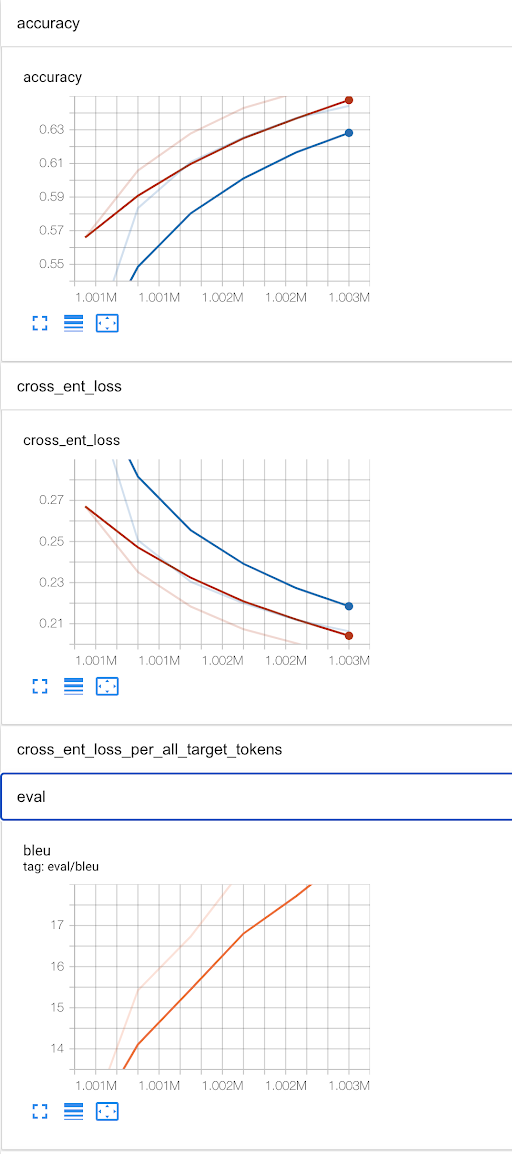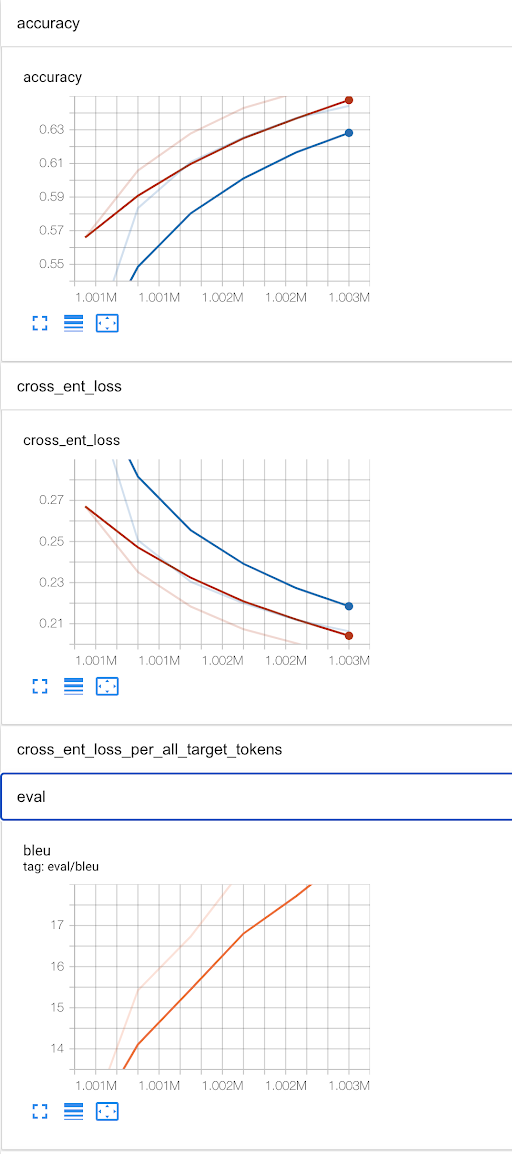

### Explore and log metrics

After the job is completed, you can explore the evaluation metrics in the run
directory of the job and log them to the experiment.

**Note**: The T5X job might take a long time to run, depending on the task. If
the job takes too long, you might
[lose your Jupyter kernel or the kernel might become unresponsive](https://cloud.google.com/vertex-ai/docs/general/troubleshooting-workbench#notebook_is_unresponsive_2).
If so, you can reimport the libraries and reset the details for the run in order
to explore the metrics

To explore jobs, get the list of experiment runs and the run directory from
Vertex AI Experiments for the experiment.

In [ ]:
# Get all experiment runs and run directories
utils.get_all_experiment_run_directories(EXPERIMENT_NAME)

Select the run ID and run directory for your experiment from the list of runs.

In [ ]:
RUN_ID = '<YOUR PREVIOUS RUN ID>' # Select a run id from the list of experiment runs
RUN_DIR = '<YOUR RUN DIR>' # Select the run directory for your run from the list of experiment runs

In [ ]:
print(f"RUN_ID = {RUN_ID}")
print(f"RUN_DIR = {RUN_DIR}")

In [ ]:
# Set path to read inference eval metrics
GCS_VAL_DIR = os.path.join(RUN_DIR, 'inference_eval/')

Call the `utils.parse_and_log_eval_metrics` function to log the fine-tuning job
metrics to the experiment from the evaluation metrics that are reported in the
logs.

The results show a dataframe with the step that achieves the highest mean value 
of scores for a group of metrics. The columns of the dataframe start with `step` 
and rest are the group of metrics evaluated. For example, for the 
English-to-German translation task the metric evaluated is 
[BLEU score](https://en.wikipedia.org/wiki/BLEU) and shown as `WMT T2T En-De` in 
the results dataframe.

In [ ]:
results = utils.parse_and_log_eval_metrics(
    summary_dir=GCS_VAL_DIR,
    run_name=RUN_ID,
    vertex_ai=vertex_ai
)
results

---

## <a name="task2"></a>Task 2: Run model evaluation on Vertex AI

This section details how to evaluate the fine-tuned T5 base model on the
translation task using a Vertex AI custom job. The evaluation job steps are
similar to those that you used for the fine-tuning job, but the steps use an
evaluation-specific Gin file.

If lose your Jupyter kernel or the kernel might become unresponsive, please 
reimport the libraries and configure experiment settings from the section 
[Preparation: Imports and initialization](#preparation).

### Configure a Gin file for the evaluation job

For evaluating the fine-tuned T5 base model for translation task, you configure
a Gin file by doing the following:

1. Import the
    [`eval.gin`](https://github.com/google-research/t5x/tree/main/t5x/configs/runs/eval.gin)
    file and the
    [Gin file for the model](https://github.com/google-research/t5x/blob/main/t5x/examples/t5/t5_1_1/base.gin)
    from T5.
1. Override the base configurations such as `MIXTURE_OR_TASK_NAME` that
    refer to the pre-configured translation task in the T5X framework.

The following listing shows the contents of the evaluation Gin file named
[`eval_t511_base_wmt.gin`](http://configs/eval_t511_base_wmt.gin) in the repo:

In [ ]:
! cat ../configs/eval_t511_base_wmt.gin

In [ ]:
# Specify the Gin file path(s) for the task
GIN_FILES = ['../configs/eval_t511_base_wmt.gin']  # Change to your Gin file path

### Configure the Vertex AI custom job

Configure the custom job run ID, name, and base output directory for the run. 
The `RUN_NAME` value can be arbitrary. We recommend setting it to a specific
task or topology so that you can identify the run when you're exploring the
experiment. For example, use `t5-eval-v2-8`, where `t5` is the model,
`eval` is the task, and `v2-8` is the TPU topology.

In [ ]:
EVAL_RUN_NAME = f'<YOUR RUN NAME>' # Change to your run name for the custom job
EVAL_RUN_ID = f'{EXPERIMENT_NAME}-{EVAL_RUN_NAME}-{datetime.now().strftime("%Y%m%d%H%M")}'
EVAL_RUN_DIR = f'{EXPERIMENT_RUNS}/{EVAL_RUN_ID}'

Specify the run mode as `eval` to run the T5X launch script in evaluation
mode.

In [ ]:
RUN_MODE = 'eval'

### Configure runtime parameters for evaluation

Running an evaluation job requires you to set the location of the model
checkpoint (`CHECKPOINT_PATH`) and to set the output path to the evaluation
results (`EVAL_OUTPUT_DIR`). You can specify these parameters for the job by
configuring `GIN_OVERWRITES`.

Configure the path to the fine-tuned model checkpoint. You can get this path
from Vertex AI Experiments using the experiment name and run ID. Run the
following function to get the list of experiment runs and the run directory
where checkpoints are located.

In [ ]:
# Get all experiment runs and run directories
utils.get_all_experiment_run_directories(EXPERIMENT_NAME)

The model checkpoint path is a subfolder under the `RUN_DIR` folder, with the
prefix `checkpoint_`. There can be multiple checkpoint folders. Pick the model
checkpoint that you want to evaluate the model with, as shown in the following
example:

``` shell
! gcloud storage ls $RUN_DIR
      gs://{BUCKET_NAME}/experiments/{EXPERIMENT_NAME}/runs/{RUN_ID}/checkpoint_1000000/
      gs://{BUCKET_NAME}/experiments/{EXPERIMENT_NAME}/runs/{RUN_ID}/checkpoint_1005000/
```

In [ ]:
! gcloud storage ls '<YOUR PREVIOUS RUN DIRECTORY>' # Change to the previous run directory

In [ ]:
CHECKPOINT_PATH = '<YOUR MODEL CHECKPOINT PATH>' # Change to the path where model checkpoint exists

Configure runtime parameters for evaluation.

In [ ]:
# Specify parameters to be overwritten in Gin files
GIN_OVERWRITES = [
    'USE_CACHED_TASKS=False',
    f'CHECKPOINT_PATH="{CHECKPOINT_PATH}"',
    f'EVAL_OUTPUT_DIR="{EVAL_RUN_DIR}"'
]

To help with troubleshooting, display the values of local variables.

In [ ]:
for key in [
    "PROJECT_ID", "REGION", "BUCKET", "TENSORBOARD_NAME", "TENSORBOARD_ID", 
    "IMAGE_NAME", "IMAGE_URI", 
    "EXPERIMENT_NAME", "EXPERIMENT_WORKSPACE", "EXPERIMENT_RUNS", 
    "TFDS_DATA_DIR", "GIN_FILES", "GIN_OVERWRITES", 
    "EVAL_RUN_NAME", "EVAL_RUN_ID", "EVAL_RUN_DIR", "RUN_MODE",
    "CHECKPOINT_PATH"]:
        print(f"{key}={eval(key)}")

### Create the Vertex AI custom job

Configure the worker pool specification based on TPU availability in the region.
See
[Vertex AI locations](https://cloud.google.com/vertex-ai/docs/general/locations#accelerators)
for details.

In [ ]:
# Define worker pool resource specification
# Machine to run the custom job on. For TPUs, use `cloud-tpu`.
MACHINE_TYPE = 'cloud-tpu'
# Accelerator type to attach to the machine. For TPUs, use `TPU_V2`, `TPU_V3`.
ACCELERATOR_TYPE = 'TPU_V2'
# Number of accelerators to attach to the machine.
# For TPUs, specify the number of cores to be provisioned.
ACCELERATOR_COUNT = 8

Create the custom job spec.

In [ ]:
job = utils.create_t5x_custom_job(
    display_name=EVAL_RUN_ID,
    machine_type=MACHINE_TYPE,
    accelerator_type=ACCELERATOR_TYPE,
    accelerator_count=ACCELERATOR_COUNT,
    image_uri=IMAGE_URI,
    run_mode=RUN_MODE,
    gin_files=GIN_FILES,
    model_dir=CHECKPOINT_PATH,
    tfds_data_dir=TFDS_DATA_DIR,
    gin_overwrites=GIN_OVERWRITES
)

In [ ]:
job.job_spec

### Submit the custom job to Vertex AI and track the experiment

The `submit_and_track_t5x_vertex_job` function launches the T5X script in
evaluation mode with the fine-tuned model checkpoint and writes evaluation
metrics. To monitor progress of the job, click the URL in the cell output. The
URL goes to the Vertex AI Custom Job console for the job.

In [ ]:
utils.submit_and_track_t5x_vertex_job(
    custom_job=job,
    job_display_name=EVAL_RUN_ID,
    run_name=EVAL_RUN_ID,
    experiment_name=EXPERIMENT_NAME,
    execution_name=EVAL_RUN_ID,
    tfds_data_dir=TFDS_DATA_DIR,
    model_dir=EVAL_RUN_DIR,
    vertex_ai=vertex_ai,
    run_mode=RUN_MODE
)

### Explore and log metrics

After the job is completed, you can explore the evaluation metrics. 

Call the `utils.parse_and_log_eval_metrics` function to parse the events in the
run directory and log them to the experiment in Vertex AI Experiments.

The results show a dataframe with the step that achieves the highest mean value 
of scores for a group of metrics. The columns of the dataframe start with `step` 
and rest are the group of metrics evaluated. For example, for the 
English-to-German translation task the metric evaluated is 
[BLEU score](https://en.wikipedia.org/wiki/BLEU) and shown as `WMT T2T En-De` in 
the results dataframe.

In [ ]:
GCS_EVAL_DIR = os.path.join(EVAL_RUN_DIR, 'inference_eval')

results = utils.parse_and_log_eval_metrics(
    summary_dir=GCS_EVAL_DIR,
    run_name=EVAL_RUN_ID,
    vertex_ai=vertex_ai
)
results

---

## <a name="task3"></a>Task 3: Run batch inference on Vertex AI

This section details how to run a batch inference job with the fine-tuned T5X
base model for the translation task on Vertex AI. The inference job steps are
similar to those that you used for the evaluation job, but the steps use an
inference-specific Gin file.

If lose your Jupyter kernel or the kernel might become unresponsive, please 
reimport the libraries and configure experiment settings from the section 
[Preparation: Imports and initialization](#preparation).

### Configure a Gin file for the batch inference job

For running batch inference with the fine-tuned T5 base model for the
translation task, you configure a Gin file by doing the following:

1. Import the
    [`infer.gin`](https://github.com/google-research/t5x/tree/main/t5x/configs/runs/infer.gin)
    file and the
    [Gin file for the model](https://github.com/google-research/t5x/blob/main/t5x/examples/t5/t5_1_1/base.gin)
    from T5.
1. Override the base configurations such as the `MIXTURE_OR_TASK_NAME` that
    refer to the pre-configured translation task in the T5X framework.

The following listing shows the contents of the evaluation Gin file named
[`infer_t511_base_wmt.gin`](configs/infer_t511_base_wmt.gin) in the repo:

In [ ]:
! cat ../configs/infer_t511_base_wmt.gin

In [ ]:
# Specify the Gin file path(s) for the task
GIN_FILES = ['../configs/infer_t511_base_wmt.gin']  # Change to your Gin file path

### Configure the Vertex AI custom job

Configure the custom job run ID, name, and base output directory for the run.
The `RUN_NAME` value can be arbitrary. We recommend setting it to a specific
task or topology so that you can identify the run when you're exploring the
experiment. For example, use `t5-infer-v2-8`, where `t5` is the model,
`infer` is the task, and `v2-8` is the TPU topology.

In [ ]:
INFER_RUN_NAME = f'<YOUR RUN NAME>' # Change to your run name for the custom job
INFER_RUN_ID = f'{EXPERIMENT_NAME}-{INFER_RUN_NAME}-{datetime.now().strftime("%Y%m%d%H%M")}'
INFER_RUN_DIR = f'{EXPERIMENT_RUNS}/{INFER_RUN_ID}'

Specify the run mode as `infer` to run the T5X launch script in inference
mode.

In [ ]:
RUN_MODE = 'infer'

### Configure runtime parameters for inference

Running an inference job requires you to set the location of the model
checkpoint (`CHECKPOINT_PATH`) and output path to the inference results
(`INFER_OUTPUT_DIR`). You can specify these parameters for the job by
configuring `GIN_OVERWRITES`.

Configure the path to the fine-tuned model checkpoint. You can get this path
from Vertex AI Experiments by using the experiment name and run ID. Run the
following function to get the list of experiment runs and the run directory
where checkpoints are located.

In [ ]:
# Get all experiment runs and run directories
utils.get_all_experiment_run_directories(EXPERIMENT_NAME)

The model checkpoint path is a subfolder under the `RUN_DIR` folder, with the
prefix `checkpoint_`. There can be multiple checkpoint folders. Pick the model
checkpoint that you want to evaluate the model with, as shown in the following
example:
``` shell
! gcloud storage ls $RUN_DIR
      gs://{BUCKET_NAME}/experiments/{EXPERIMENT_NAME}/runs/{RUN_ID}/checkpoint_1000000/
      gs://{BUCKET_NAME}/experiments/{EXPERIMENT_NAME}/runs/{RUN_ID}/checkpoint_1005000/
```

In [ ]:
! gcloud storage ls '<YOUR PREVIOUS RUN DIRECTORY>' # Change to the previous run directory

In [ ]:
CHECKPOINT_PATH = '<YOUR MODEL CHECKPOINT PATH>' # Change to the path where model checkpoint exists

Configure runtime parameters for the inference.

In [ ]:
# Specify parameters to be overwritten in Gin files
GIN_OVERWRITES = [
    'USE_CACHED_TASKS=False',
    f'CHECKPOINT_PATH="{CHECKPOINT_PATH}"',
    f'INFER_OUTPUT_DIR="{INFER_RUN_DIR}"'
]

To help with troubleshooting, display the values of local variables.

In [ ]:
for key in [
    "PROJECT_ID", "REGION", "BUCKET", "TENSORBOARD_NAME", "TENSORBOARD_ID", 
    "IMAGE_NAME", "IMAGE_URI", 
    "EXPERIMENT_NAME", "EXPERIMENT_WORKSPACE", "EXPERIMENT_RUNS", 
    "TFDS_DATA_DIR", "GIN_FILES", "GIN_OVERWRITES", 
    "INFER_RUN_NAME", "INFER_RUN_ID", "INFER_RUN_DIR", "RUN_MODE",
    "CHECKPOINT_PATH"
]:
    print(f"{key}={eval(key)}")

### Create the Vertex AI custom job

Configure the worker pool specification based on TPU availability in the region.
See
[Vertex AI locations](https://cloud.google.com/vertex-ai/docs/general/locations#accelerators)
for details.

In [ ]:
# Define worker pool resource specification
# Machine to run the custom job on. For TPUs, use `cloud-tpu`.
MACHINE_TYPE = 'cloud-tpu'
# Accelerator type to attach to the machine. For TPUs, use `TPU_V2`, `TPU_V3`.
ACCELERATOR_TYPE = 'TPU_V2'
# Number of accelerators to attach to the machine.
# For TPUs, specify the number of cores to be provisioned.
ACCELERATOR_COUNT = 8

Create the custom job spec.

In [ ]:
job = utils.create_t5x_custom_job(
    display_name=INFER_RUN_ID,
    machine_type=MACHINE_TYPE,
    accelerator_type=ACCELERATOR_TYPE,
    accelerator_count=ACCELERATOR_COUNT,
    image_uri=IMAGE_URI,
    run_mode=RUN_MODE,
    gin_files=GIN_FILES,
    model_dir=CHECKPOINT_PATH,
    tfds_data_dir=TFDS_DATA_DIR,
    gin_overwrites=GIN_OVERWRITES
)

In [ ]:
job.job_spec

### Submit the custom job to Vertex AI and track the experiment

The `submit_and_track_tx5_vertex_job` function launches the T5X script in
inference mode with the fine-tuned model checkpoint specification. The function
submits the job to Vertex AI, which generates inferences results and writes them
to the Cloud Storage bucket. To monitor progress of the job, click the URL in
the cell output. The URL goes to the Vertex AI Custom Job console for the job.

In [ ]:
utils.submit_and_track_t5x_vertex_job(
    custom_job=job,
    job_display_name=INFER_RUN_ID,
    run_name=INFER_RUN_ID,
    experiment_name=EXPERIMENT_NAME,
    execution_name=INFER_RUN_ID,
    tfds_data_dir=TFDS_DATA_DIR,
    model_dir=INFER_RUN_DIR,
    vertex_ai=vertex_ai,
    run_mode=RUN_MODE
)

### Explore batch inference results

The batch inference job writes inference results to the run directory that you
configured. The output is written in JSON lines (`.jsonl`) format.

In [ ]:
! gcloud storage ls $INFER_RUN_DIR

The following example is a snippet from the output of the batch inference job
for the translation task from a fine-tuned
[WMT English-to-German translation](https://www.tensorflow.org/datasets/catalog/wmt_t2t_translate)
model.

``` json
{
	"inputs": {
		"inputs_pretokenized": "translate English to German: As recently as last Tuesday, the Nasdaq indices were not calculated for one hour due to data transfer errors.",
		"targets_pretokenized": "Erst am Dienstag waren die Indizes der Nasdaq wegen Fehlern im Datentransport eine Stunde lang nicht berechnet worden."
	},
	"prediction": "Erst am vergangenen Dienstag wurden die Nasdaq-Indexe wegen Daten\u00fcbertragungen f\u00fcr eine Stunde nicht berechnet."
}
```

---

## What's next?

This notebook template covers how to run a T5X job for fine-tuning, evaluation,
and inference tasks on Vertex AI.

You can copy this notebook template for a specific task or dataset or
configuration and then make changes as needed to run the T5X job on Vertex AI.
Refer to other notebooks in the
[notebooks directory](/) of this repo as
inspiration.